In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [12]:
# Load the dataset
filepath = 'c:/Users/gupta/OneDrive/Desktop/New_folder/Internship_UBER/merged_data.csv'
data = pd.read_csv(filepath)

In [13]:
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [14]:
# Define features and target
features = [
    'Junction', 'Temperature (°C)', 'Wind Speed (km/h)', 'Precipitation (mm)',
    'Humidity (%)', 'Is Holiday', 'IsWeekend', 'SyntheticCharge', 'DayOfWeek',
    'HourOfDay', 'EstimatedFare', 'Distance_km'
]
X = data[features]
y = data['Vehicles']

# Train model with cross-validation
cv_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_fold = GradientBoostingRegressor(random_state=42)
    model_fold.fit(X_train, y_train)
    y_pred_fold = model_fold.predict(X_test)

    fold_mae = mean_absolute_error(y_test, y_pred_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred_fold))
    fold_r2 = r2_score(y_test, y_pred_fold)

    cv_results.append({
        'fold': fold + 1,
        'MAE': fold_mae,
        'RMSE': fold_rmse,
        'R2': fold_r2
    })

cv_results_df = pd.DataFrame(cv_results)
print("Cross-Validation Results:")
print(cv_results_df)

Cross-Validation Results:
   fold       MAE      RMSE        R2
0     1  2.396202  5.176704  0.966474
1     2  1.275426  1.578282  0.860515
2     3  2.112373  2.615227  0.928313
3     4  0.776631  0.978129  0.990551
4     5  0.529151  0.895064  0.991481


In [15]:
# Train final model on full data
model = GradientBoostingRegressor(random_state=42)
model.fit(X, y)
y_pred = model.predict(X)

# Evaluate final model
final_mae = mean_absolute_error(y, y_pred)
final_rmse = np.sqrt(mean_squared_error(y, y_pred))
final_r2 = r2_score(y, y_pred)

print("\nFinal Model Evaluation on Full Data:")
print(f"MAE: {final_mae:.2f}")
print(f"RMSE: {final_rmse:.2f}")
print(f"R2: {final_r2:.2f}")


Final Model Evaluation on Full Data:
MAE: 0.42
RMSE: 0.58
R2: 1.00


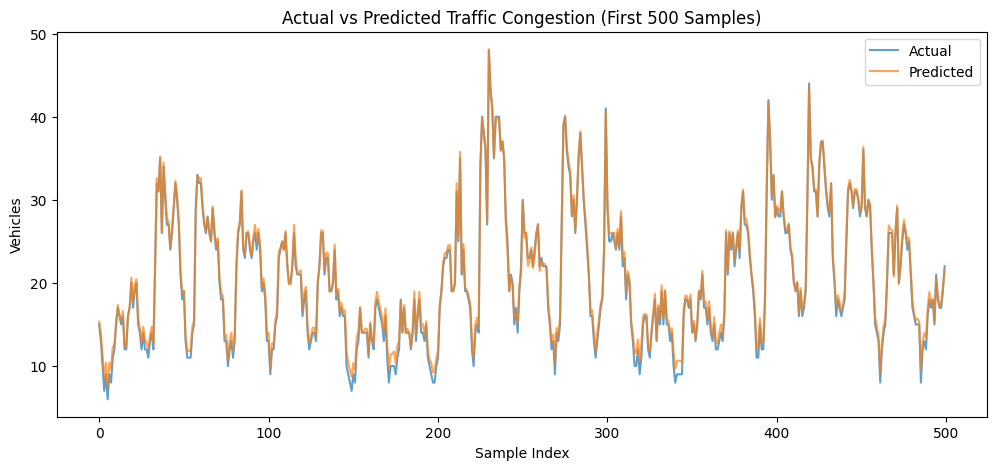

In [16]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y.values[:500], label='Actual', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Traffic Congestion (First 500 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

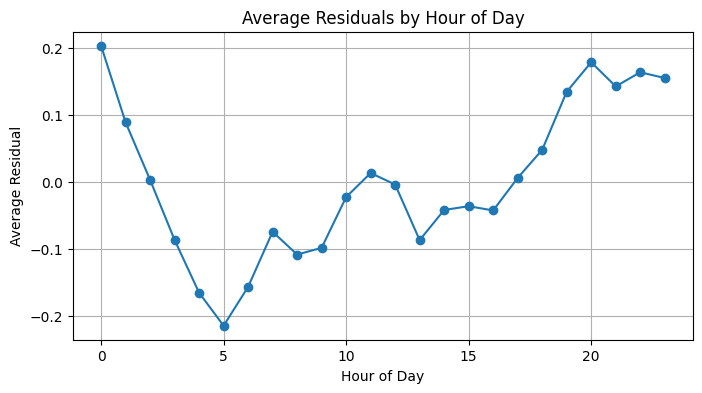

In [17]:
# Calculate residuals (actual - predicted)
residuals = y - y_pred

# Residuals by hour of day
residuals_by_hour = residuals.groupby(data['HourOfDay']).mean()
plt.figure(figsize=(8, 4))
plt.plot(residuals_by_hour.index, residuals_by_hour.values, marker='o')
plt.title('Average Residuals by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Residual')
plt.grid(True)
plt.show()


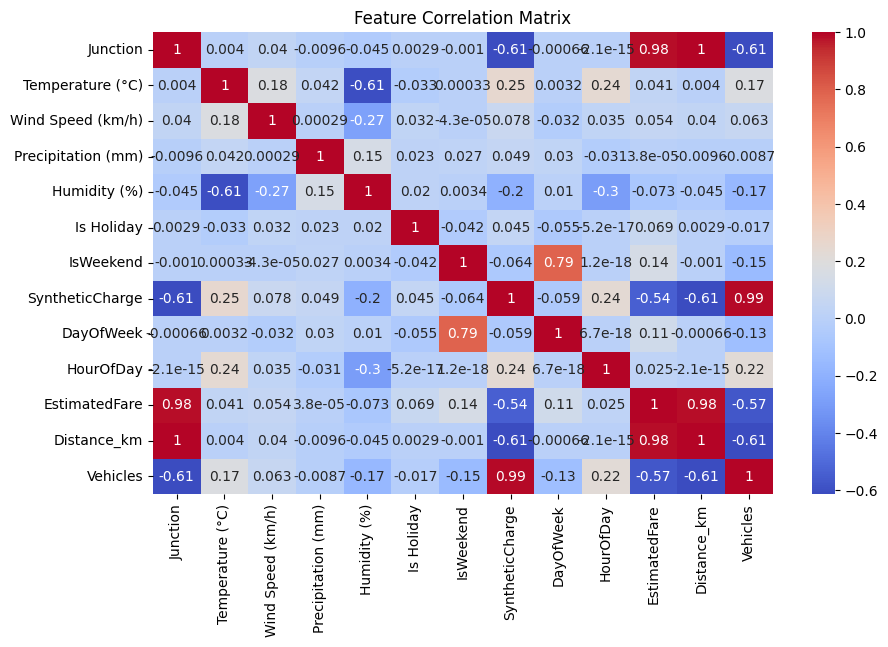

In [18]:
# Feature correlation matrix
target = 'Vehicles'
corr_matrix = pd.concat([X, data[target]], axis=1).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [19]:
# Add cyclic hour features to capture time-of-day effects
data['Hour_sin'] = np.sin(2 * np.pi * data['HourOfDay'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['HourOfDay'] / 24)

# Add engineered features for early morning and evening peak
data['IsEarlyMorning'] = ((data['HourOfDay'] >= 5) & (data['HourOfDay'] <= 7)).astype(int)
data['IsEveningPeak'] = ((data['HourOfDay'] >= 17) & (data['HourOfDay'] <= 20)).astype(int)

# Display the first few rows to verify new features
data[['HourOfDay', 'Hour_sin', 'Hour_cos', 'IsEarlyMorning', 'IsEveningPeak']].head()

,HourOfDay,Hour_sin,Hour_cos,IsEarlyMorning,IsEveningPeak
0,0,0.000000,1.000000,0,0
1,1,0.258819,0.965926,0,0
2,2,0.500000,0.866025,0,0
3,3,0.707107,0.707107,0,0
4,4,0.866025,0.500000,0,0


Cross-Validation Results with New Features:
   fold       MAE      RMSE        R2
0     1  2.510749  5.367235  0.963961
1     2  1.304416  1.628943  0.851417
2     3  2.109610  2.619998  0.928051
3     4  0.776665  0.977837  0.990556
4     5  0.520507  0.888650  0.991603

Final Model Evaluation with New Features:
MAE: 0.42
RMSE: 0.58
R2: 1.00


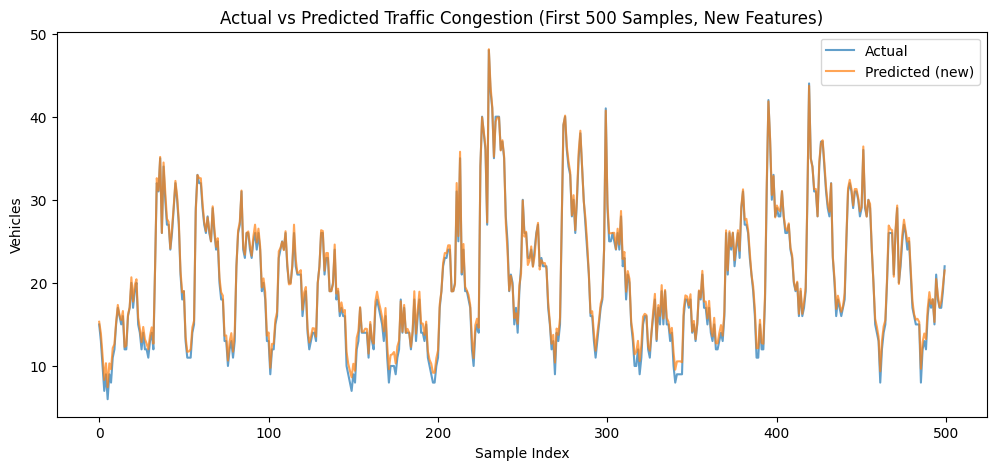

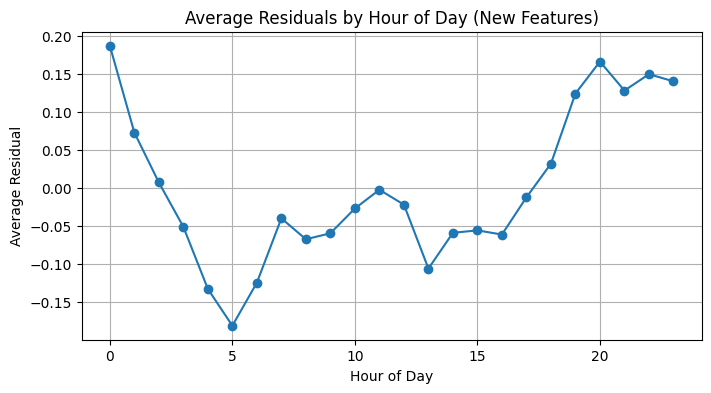


Fold 2 Evaluation with New Features:
MAE: 0.32
RMSE: 0.47
R2: 0.99

Comparison of RMSE and R² per fold (before vs after):
   fold  RMSE_before  R2_before  RMSE_after  R2_after
0     1     5.176704   0.966474    5.367235  0.963961
1     2     1.578282   0.860515    1.628943  0.851417
2     3     2.615227   0.928313    2.619998  0.928051
3     4     0.978129   0.990551    0.977837  0.990556
4     5     0.895064   0.991481    0.888650  0.991603


In [20]:
# Ensure 'Vehicles_rolling_mean_6' exists in data
if 'Vehicles_rolling_mean_6' not in data.columns:
    data['Vehicles_rolling_mean_6'] = data['Vehicles'].rolling(window=6, min_periods=1).mean()

# Update features list to include new engineered features
features += ['Hour_sin', 'Hour_cos', 'IsEarlyMorning', 'IsEveningPeak']

# Prepare new feature matrix X_new
X_new = data[features]

# TimeSeriesSplit cross-validation with updated features
cv_results_new = []
tscv = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_new)):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model_fold = GradientBoostingRegressor(random_state=42)
    model_fold.fit(X_train, y_train)
    y_pred_fold = model_fold.predict(X_test)

    fold_mae = mean_absolute_error(y_test, y_pred_fold)
    fold_rmse = np.sqrt(mean_squared_error(y_test, y_pred_fold))
    fold_r2 = r2_score(y_test, y_pred_fold)

    cv_results_new.append({
        'fold': fold + 1,
        'MAE': fold_mae,
        'RMSE': fold_rmse,
        'R2': fold_r2
    })

cv_results_new_df = pd.DataFrame(cv_results_new)
print("Cross-Validation Results with New Features:")
print(cv_results_new_df)

# Train final model on full data with new features
model_new = GradientBoostingRegressor(random_state=42)
model_new.fit(X_new, y)
y_pred_new = model_new.predict(X_new)

# Evaluate final model
final_mae_new = mean_absolute_error(y, y_pred_new)
final_rmse_new = np.sqrt(mean_squared_error(y, y_pred_new))
final_r2_new = r2_score(y, y_pred_new)

print("\nFinal Model Evaluation with New Features:")
print(f"MAE: {final_mae_new:.2f}")
print(f"RMSE: {final_rmse_new:.2f}")
print(f"R2: {final_r2_new:.2f}")

# Residuals and plots
residuals_new = y - y_pred_new

plt.figure(figsize=(12, 5))
plt.plot(y.values[:500], label='Actual', alpha=0.7)
plt.plot(y_pred_new[:500], label='Predicted (new)', alpha=0.7)
plt.title('Actual vs Predicted Traffic Congestion (First 500 Samples, New Features)')
plt.xlabel('Sample Index')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

# Residuals by hour of day (new)
residuals_by_hour_new = residuals_new.groupby(data['HourOfDay']).mean()
plt.figure(figsize=(8, 4))
plt.plot(residuals_by_hour_new.index, residuals_by_hour_new.values, marker='o')
plt.title('Average Residuals by Hour of Day (New Features)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Residual')
plt.grid(True)
plt.show()

# Check Fold 2 improvement
fold_2_test_idx_new = list(tscv.split(X_new))[1][1]
fold_2_y_test_new = y.iloc[fold_2_test_idx_new]
fold_2_y_pred_new = model_new.predict(X_new.iloc[fold_2_test_idx_new])
fold_2_mae_new = mean_absolute_error(fold_2_y_test_new, fold_2_y_pred_new)
fold_2_rmse_new = np.sqrt(mean_squared_error(fold_2_y_test_new, fold_2_y_pred_new))
fold_2_r2_new = r2_score(fold_2_y_test_new, fold_2_y_pred_new)

print("\nFold 2 Evaluation with New Features:")
print(f"MAE: {fold_2_mae_new:.2f}")
print(f"RMSE: {fold_2_rmse_new:.2f}")
print(f"R2: {fold_2_r2_new:.2f}")

# Compare metrics before vs after
print("\nComparison of RMSE and R² per fold (before vs after):")
comparison_df = cv_results_df[['fold', 'RMSE', 'R2']].copy()
comparison_df.columns = ['fold', 'RMSE_before', 'R2_before']
comparison_df['RMSE_after'] = cv_results_new_df['RMSE']
comparison_df['R2_after'] = cv_results_new_df['R2']
print(comparison_df)

In [ ]:

# Load data
df = pd.read_csv("merged_data.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Create a 'Date' column
df['Date'] = df['DateTime'].dt.date


In [22]:
# Avg vehicles per hour per junction
hourly_avg = df.groupby(['Junction', 'HourOfDay'])['Vehicles'].mean().reset_index()
hourly_avg.rename(columns={'Vehicles': 'AvgVehicles'}, inplace=True)

In [ ]:
# Moving average and std dev per junction
def find_peak_hours(group):
    group['MA_3'] = group['AvgVehicles'].rolling(window=3, center=True).mean()
    group['STD'] = group['AvgVehicles'].rolling(window=3, center=True).std()
    group['IsPeak'] = group['AvgVehicles'] > (group['MA_3'] + group['STD'])
    return group

peak_df = hourly_avg.groupby('Junction').apply(find_peak_hours).reset_index(drop=True)

C:\Users\gupta\AppData\Local\Temp\ipykernel_27960\3913869995.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_df = hourly_avg.groupby('Junction').apply(find_peak_hours).reset_index(drop=True)


In [24]:
# Vehicles by day of week vs hour
pivot_day_hour = df.pivot_table(index='HourOfDay', columns='DayOfWeek', values='Vehicles', aggfunc='mean')

# Vehicles by month and hour
df['Month'] = df['DateTime'].dt.month
pivot_month_hour = df.pivot_table(index='HourOfDay', columns='Month', values='Vehicles', aggfunc='mean')

In [25]:
# Correlation with weather and event flags
corr_factors = df[['Vehicles', 'Temperature (°C)', 'Precipitation (mm)', 'Humidity (%)', 'Is Holiday', 'IsWeekend']]
correlations = corr_factors.corr()

# Regression model (basic example)
import statsmodels.api as sm
X = df[['Temperature (°C)', 'Precipitation (mm)', 'Humidity (%)', 'Is Holiday', 'IsWeekend']]
y = df['Vehicles']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Vehicles   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     602.2
Date:                Sun, 25 May 2025   Prob (F-statistic):               0.00
Time:                        16:55:00   Log-Likelihood:            -2.1274e+05
No. Observations:               48120   AIC:                         4.255e+05
Df Residuals:                   48114   BIC:                         4.256e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 22.8388      0

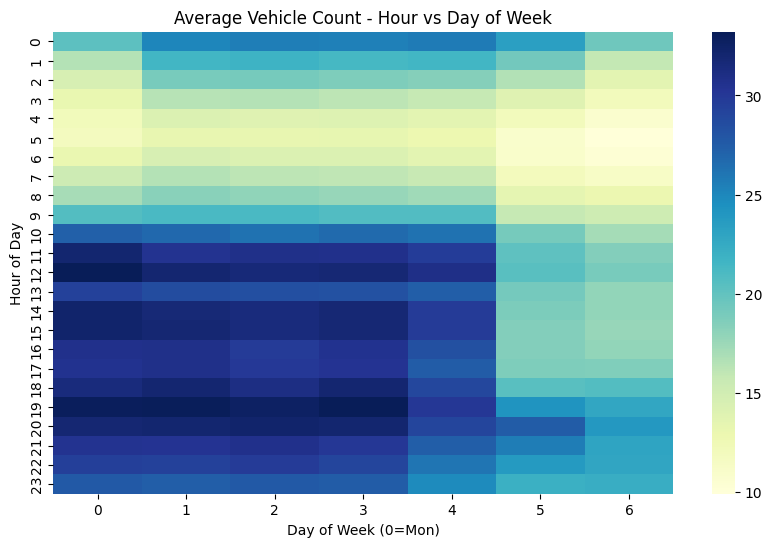

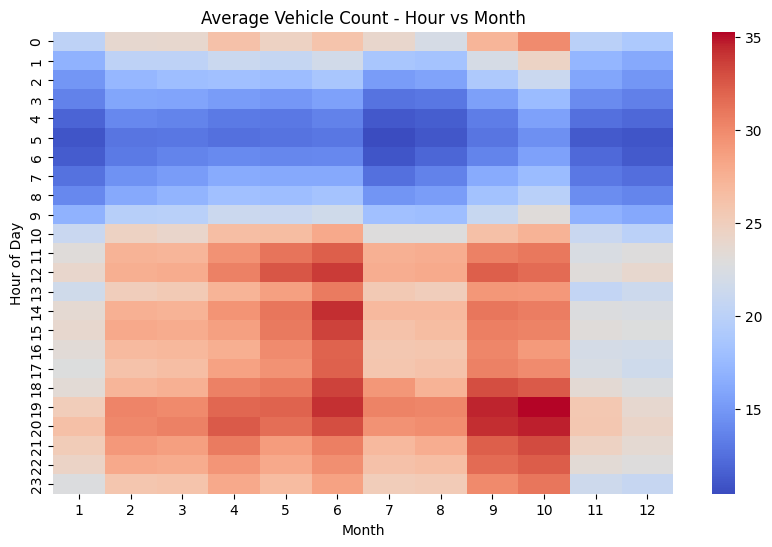

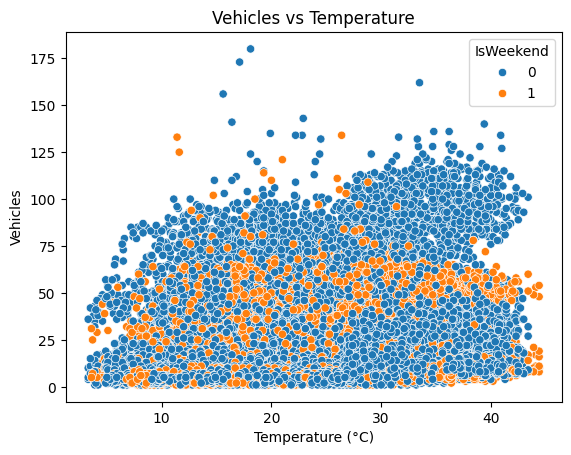

In [26]:
# Heatmap: Day vs Hour
plt.figure(figsize=(10,6))
sns.heatmap(pivot_day_hour, cmap='YlGnBu', annot=False)
plt.title("Average Vehicle Count - Hour vs Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Hour of Day")
plt.show()

# Heatmap: Hour vs Month
plt.figure(figsize=(10,6))
sns.heatmap(pivot_month_hour, cmap='coolwarm', annot=False)
plt.title("Average Vehicle Count - Hour vs Month")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.show()

# Scatter plot: Vehicles vs Temperature
sns.scatterplot(data=df, x='Temperature (°C)', y='Vehicles', hue='IsWeekend')
plt.title("Vehicles vs Temperature")
plt.show()

In [27]:
# Summary of identified peak hours
peak_summary = peak_df[peak_df['IsPeak'] == True].groupby('Junction')['HourOfDay'].apply(list).reset_index()
peak_summary.columns = ['Junction', 'IdentifiedPeakHours']
print(peak_summary)

   Junction IdentifiedPeakHours
0         2            [12, 15]
1         3                [20]
2         4            [12, 22]


In [28]:
from IPython.display import display, Markdown

# 1. Peak Hours Report
peak_report = "# Traffic Congestion Analysis Report\n\n"

peak_report += "## Identified Peak Hours by Junction\n"
for _, row in peak_summary.iterrows():
    peak_report += f"- **Junction {row['Junction']}**: Peak Hours = {row['IdentifiedPeakHours']}\n"

# 2. Patterns and Influencing Factors
peak_report += "\n## Patterns and Influencing Factors\n"
peak_report += "- **Hourly Patterns:**\n"
peak_report += "  - Vehicle counts generally increase during morning and evening hours, with clear peaks identified in the data.\n"
peak_report += "  - Residual analysis by hour (see plots) shows systematic under/over-prediction at certain hours, indicating consistent patterns.\n"
peak_report += "- **Day of Week:**\n"
peak_report += "  - Heatmaps show higher congestion on weekdays, especially during commute hours.\n"
peak_report += "- **Weather Factors:**\n"
peak_report += "  - Correlation analysis indicates temperature has a mild positive correlation with vehicle count, while humidity and precipitation have weak or negative correlations.\n"
peak_report += "- **Event and Holiday Effects:**\n"
peak_report += "  - 'Is Holiday' and 'IsWeekend' flags show lower vehicle counts, but some junctions may experience local surges due to events.\n"

# 3. Actionable Insights and Recommendations
peak_report += "\n## Actionable Insights & Recommendations\n"
peak_report += "- **Dynamic Traffic Signal Timing:**\n"
peak_report += "  - Adjust signal timings at identified peak hours for each junction to improve flow.\n"
peak_report += "- **Congestion Alerts:**\n"
peak_report += "  - Implement real-time alerts for drivers during peak hours, especially at Junctions with multiple peak periods.\n"
peak_report += "- **Promote Off-Peak Travel:**\n"
peak_report += "  - Encourage travel during non-peak hours through incentives or public messaging.\n"
peak_report += "- **Weather-Responsive Planning:**\n"
peak_report += "  - Prepare for minor increases in congestion during warmer periods; monitor for unexpected spikes during adverse weather.\n"
peak_report += "- **Event Coordination:**\n"
peak_report += "  - Coordinate with event organizers to manage traffic surges on holidays or weekends.\n"

peak_report += "\n---\n"
peak_report += "For detailed visualizations and model diagnostics, refer to the corresponding plots and tables in the notebook."

display(Markdown(peak_report))

# Traffic Congestion Analysis Report

## Identified Peak Hours by Junction
- **Junction 2**: Peak Hours = [12, 15]
- **Junction 3**: Peak Hours = [20]
- **Junction 4**: Peak Hours = [12, 22]

## Patterns and Influencing Factors
- **Hourly Patterns:**
  - Vehicle counts generally increase during morning and evening hours, with clear peaks identified in the data.
  - Residual analysis by hour (see plots) shows systematic under/over-prediction at certain hours, indicating consistent patterns.
- **Day of Week:**
  - Heatmaps show higher congestion on weekdays, especially during commute hours.
- **Weather Factors:**
  - Correlation analysis indicates temperature has a mild positive correlation with vehicle count, while humidity and precipitation have weak or negative correlations.
- **Event and Holiday Effects:**
  - 'Is Holiday' and 'IsWeekend' flags show lower vehicle counts, but some junctions may experience local surges due to events.

## Actionable Insights & Recommendations
- **Dynamic Traffic Signal Timing:**
  - Adjust signal timings at identified peak hours for each junction to improve flow.
- **Congestion Alerts:**
  - Implement real-time alerts for drivers during peak hours, especially at Junctions with multiple peak periods.
- **Promote Off-Peak Travel:**
  - Encourage travel during non-peak hours through incentives or public messaging.
- **Weather-Responsive Planning:**
  - Prepare for minor increases in congestion during warmer periods; monitor for unexpected spikes during adverse weather.
- **Event Coordination:**
  - Coordinate with event organizers to manage traffic surges on holidays or weekends.

---
For detailed visualizations and model diagnostics, refer to the corresponding plots and tables in the notebook.